# Downside!

In [7]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import edhec_risk_kit as erk
import numpy as np


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
hfi = erk.get_hfi_returns()

In [9]:
hfi.std(ddof=0) #measures both upside and downside deviation

Convertible Arbitrage     0.016536
CTA Global                0.023290
Distressed Securities     0.017009
Emerging Markets          0.032476
Equity Market Neutral     0.008115
Event Driven              0.016712
Fixed Income Arbitrage    0.011517
Global Macro              0.014694
Long/Short Equity         0.019897
Merger Arbitrage          0.009600
Relative Value            0.011462
Short Selling             0.047655
Funds Of Funds            0.015536
dtype: float64

In [10]:
hfi[hfi<0].std(ddof=0)

Convertible Arbitrage     0.019540
CTA Global                0.012443
Distressed Securities     0.015185
Emerging Markets          0.028039
Equity Market Neutral     0.009566
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Global Macro              0.006579
Long/Short Equity         0.014051
Merger Arbitrage          0.008875
Relative Value            0.012244
Short Selling             0.027283
Funds Of Funds            0.012122
dtype: float64

In [11]:
erk.semideviation(hfi)

Convertible Arbitrage     0.019540
CTA Global                0.012443
Distressed Securities     0.015185
Emerging Markets          0.028039
Equity Market Neutral     0.009566
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Global Macro              0.006579
Long/Short Equity         0.014051
Merger Arbitrage          0.008875
Relative Value            0.012244
Short Selling             0.027283
Funds Of Funds            0.012122
dtype: float64

# VaR and CVaR

- Historic VaR
- Parametric VaR - Gaussian
- Modified Cornish-Fisher VaR (accounts for non-gaussian distribution)

In [12]:
np.percentile(hfi, 5, axis = 0) #5th percentile per column

array([-0.01576, -0.03169, -0.01966, -0.04247, -0.00814, -0.02535,
       -0.00787, -0.01499, -0.02598, -0.01047, -0.01174, -0.06783,
       -0.02047])

In [17]:
def var_historic(r, level=5):
    """
    VaR Historic
    """
    if isinstance(r, pd.DataFrame):
        return r.agg(var_historic, level = level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError('expected r to be pandas Series or DataFrame')
        
# added to toolkit

In [19]:
var_historic(hfi, 5)

Convertible Arbitrage     0.01576
CTA Global                0.03169
Distressed Securities     0.01966
Emerging Markets          0.04247
Equity Market Neutral     0.00814
Event Driven              0.02535
Fixed Income Arbitrage    0.00787
Global Macro              0.01499
Long/Short Equity         0.02598
Merger Arbitrage          0.01047
Relative Value            0.01174
Short Selling             0.06783
Funds Of Funds            0.02047
dtype: float64

In [22]:
erk.var_historic(hfi)

Convertible Arbitrage     0.01576
CTA Global                0.03169
Distressed Securities     0.01966
Emerging Markets          0.04247
Equity Market Neutral     0.00814
Event Driven              0.02535
Fixed Income Arbitrage    0.00787
Global Macro              0.01499
Long/Short Equity         0.02598
Merger Arbitrage          0.01047
Relative Value            0.01174
Short Selling             0.06783
Funds Of Funds            0.02047
dtype: float64

In [23]:
from scipy.stats import norm

In [30]:
norm.ppf(.05) #takes the 5% lvel, and returns a z-score for the normal distribution
    #this is a one-sided z score (equal to or greater than the level)

-1.6448536269514729

In [32]:
def var_gaussian(r, level=5):
    """
    returns the parametric Gaussian VaR of a series or DF
    """
    
    z = norm.pff(level/100)
    return -(r.mean() + z*r.std(ddof=0))


z = norm.ppf(.05)
-(hfi.mean() + z*hfi.std(ddof=0)) #added in cornish fisher in erk.py

Convertible Arbitrage     0.021691
CTA Global                0.034235
Distressed Securities     0.021032
Emerging Markets          0.047164
Equity Market Neutral     0.008850
Event Driven              0.021144
Fixed Income Arbitrage    0.014579
Global Macro              0.018766
Long/Short Equity         0.026397
Merger Arbitrage          0.010435
Relative Value            0.013061
Short Selling             0.080086
Funds Of Funds            0.021292
dtype: float64

In [38]:
erk.var_gaussian(hfi)

Convertible Arbitrage     0.021691
CTA Global                0.034235
Distressed Securities     0.021032
Emerging Markets          0.047164
Equity Market Neutral     0.008850
Event Driven              0.021144
Fixed Income Arbitrage    0.014579
Global Macro              0.018766
Long/Short Equity         0.026397
Merger Arbitrage          0.010435
Relative Value            0.013061
Short Selling             0.080086
Funds Of Funds            0.021292
dtype: float64

In [41]:
var_list = [erk.var_gaussian(hfi), erk.var_gaussian(hfi, modified=True), erk.var_historic(hfi)]
comparison = pd.concat(var_list, axis = 1)
comparison.columns = ['Gaussian', 'Cornish-Fisher', 'Historic']

<AxesSubplot:>

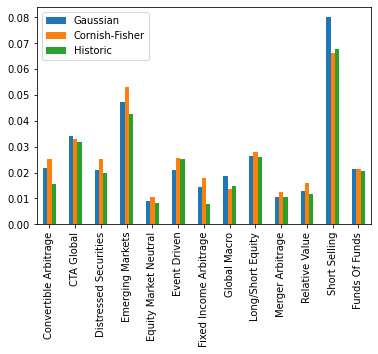

In [42]:
comparison.plot.bar()

### Beyond Var, CVar

In [44]:
def cvar_historic(r, level = 5):
    """
    Computes Conditional VaR of series or DF
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level = level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.agg(cvar_historic, level = level)
    else:
        raise TypeError('expected r to be series or DF')

In [46]:
erk.cvar_historic(hfi) #if that worst case scenario happens, the average of those losses is:

Convertible Arbitrage     0.036550
CTA Global                0.041264
Distressed Securities     0.036429
Emerging Markets          0.072364
Equity Market Neutral     0.016879
Event Driven              0.038336
Fixed Income Arbitrage    0.028257
Global Macro              0.020629
Long/Short Equity         0.041943
Merger Arbitrage          0.019143
Relative Value            0.024650
Short Selling             0.096821
Funds Of Funds            0.033207
dtype: float64